## Setup

In [1]:
# Colab
# !pip install --quiet lightning

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
# Standard library imports
import math
import os
import linecache
from itertools import chain, permutations, repeat
from pathlib import Path

# Third-party library imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
# import torch.utils.tensorboard as tb
import lightning as L
import lightning.pytorch as pl

from sklearn.preprocessing import OneHotEncoder
from torch import nn
from torch.utils.data import DataLoader, Dataset, IterableDataset

In [4]:
DEVICE = ("cuda" if torch.cuda.is_available()
            else "mps" if torch.backends.mps.is_available()
            else "cpu")
print(f'Using {DEVICE}!')
SEED = 2023

Using cuda!


---

## Data structures

In [5]:
class IterableSequenceAlternation(IterableDataset):
    """Memory efficient sequence dataset for generating the full data"""
    def __init__(self, num_unique: int, cycle_len: int):
        self.num_unique, self.cycle_len = num_unique, cycle_len
        self.perms = permutations(range(1, num_unique+1), cycle_len+1)

    def __next__(self):
        perm = list(next(self.perms))
        first_cycle = perm[:self.cycle_len]
        second_cycle = perm[:self.cycle_len-1] + [perm[-1]]

        input_seq = chain(first_cycle,
                          second_cycle,
                          repeat(0, 2*self.cycle_len))

        output_seq = chain(first_cycle,
                           second_cycle,
                           first_cycle,
                           second_cycle)

        return input_seq, output_seq

    def __iter__(self):
        return self

class SequenceAlternation(Dataset):
    """Sequence dataset used for training"""
    def __init__(self, dset_path, num_unique: int, cycle_len: int, emb=True):
        self.dset_path = dset_path
        self.num_unique = num_unique
        self.cycle_len = cycle_len
        self.seq_len = 4 * cycle_len
        self.emb = emb
        self.ohe = OneHotEncoder(max_categories=None, sparse_output=False)
        self.ohe.fit(np.arange(num_unique + 1).reshape(-1,1))  # 0: no cue

    def __getitem__(self, idx):
        line = linecache.getline(self.dset_path, idx+2) \
                .strip()    \
                .split(',')
        
        input_seq = list(map(int, line[:self.seq_len]))
        input_seq = np.asarray(input_seq)
        input_seq = self.ohe.transform(input_seq.reshape(-1, 1))
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        output_seq = list(map(int, line[self.seq_len:]))
        output_seq = np.asarray(output_seq)
        output_seq = self.ohe.transform(output_seq.reshape(-1, 1))
        output_seq = torch.tensor(output_seq, dtype=torch.float32)

        # (batched) input shape should be: (N, L, input_dim)
        if self.emb is False:
            input_seq = torch.unsqueeze(input_seq, -1)
            output_seq = torch.unsqueeze(output_seq, -1)

        return input_seq, output_seq  # 2*cycle_len, num_unique

    def validate_saved_dataset(self):
        """TODO"""
        pass

    def __len__(self):
        # no choice but to read entire file
        with open(self.dset_path, 'rbU') as f:
            num_lines = sum(1 for _ in f)
            num_obs = num_lines - 1
        return num_obs

---

## Neural networks

In [6]:
class RNN(L.LightningModule):
  """MLPs in Pytorch of an arbitrary number of hidden
  layers of potentially different sizes.
  """
  def __init__(self, in_dim=100, out_dim=2, hidden_dims=(400, 1, .0), use_bias=True, args={}):
    """
    Constructs a MultiLayerPerceptron

    Args:
      in_dim: Integer
        dimensionality of input data (784)
      out_dim: Integer
        number of output columns
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)
    """
    super().__init__()
    self.save_hyperparameters()
    self.in_dim = in_dim
    self.out_dim = out_dim
    if len(hidden_dims) != 3:
      raise ValueError('`hidden_dims` should be of size 3')
    hidden_size, nlayers, dropout = hidden_dims
    self.nlayers = nlayers
    self.hidden_size = hidden_size
    self.dropout = dropout
    self.args = args

    # Add final layer to the number of classes
    self.rnn = nn.RNN(input_size=in_dim, hidden_size=hidden_size,
                      nonlinearity='relu', num_layers=nlayers, batch_first=True,
                      dropout=dropout, bidirectional=False)
    self.fc = nn.Linear(in_features=hidden_size, out_features=out_dim, bias=use_bias)
    self.hidden_state = None

    def init_weights(m):
      if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(.01)
    self.fc.apply(init_weights)

  def forward(self, x):
    rnn_out, self.hidden_state = self.rnn(x, self.hidden_state)
    B, L, H = rnn_out.shape
    # Shape: [batch_size x max_length x hidden_dim]

    # Select the activation of the last Hidden Layer
    # rnn_out = rnn_out.view(B, L, 2, -1).sum(dim=2)
    rnn_out = rnn_out[:,:,:].contiguous()

    # Shape: [batch_size x hidden_dim]

    # Fully connected layer
    out = self.fc(rnn_out)
    if self.args['clf']: out = F.log_softmax(out, dim=-1)

    return out

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    self.batch_size = batch_size
    h0 = torch.zeros((self.nlayers,batch_size,self.hidden_size), requires_grad=False)
    self.hidden_state = h0

  def predict(self, x):
    self.hidden_state = self.hidden_state.to(x.device)
    preds = []
    batch_size = self.batch_size
    for i in range(batch_size, x.shape[0]+batch_size, batch_size):
      iptensor = x[i-batch_size:i]
      if i > x.shape[0]:
          iptensor = F.pad(iptensor, (0,0,0,0,0,i-x.shape[0]))
      pred_loc = self.forward(iptensor)
      if i > x.shape[0]:
          pred_loc = pred_loc[:batch_size-(i-x.shape[0])]
      preds.extend(pred_loc)
    out = torch.stack(preds)
    if self.args['clf']: out = F.log_softmax(out, dim=-1)
    return out

  def _step(self, batch, batch_idx) -> torch.Tensor:
    xs, ys = batch  # unpack the batch
    outs = self(xs)  # apply the model
    # print(outs.shape, ys.shape)
    loss = self.args['criterion'](outs, ys)
    return loss

  def training_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('train_loss', loss)
    return loss

  def on_after_backward(self):
    # RNN specific
    self.hidden_state.detach_()
    self.hidden_state.data.fill_(.0)

  def validation_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('val_loss', loss)
    return loss

  def test_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('test_loss', loss)
    return loss

  def configure_optimizers(self):
    args = self.args
    optimizer = torch.optim.AdamW(
      self.parameters(), weight_decay=args['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer, max_lr=args['lr'],
      epochs=args['epochs'], steps_per_epoch=self.args['num_training_batches'],
    )
    lr_scheduler = {'scheduler': scheduler, 'interval': 'step'}
    return [optimizer], [lr_scheduler]

In [45]:
class M2MRNN(L.LightningModule):
  """Continuous-time RNN in Pytorch of an arbitrary number of hidden
  layers of same sizes.
  """
  def __init__(self, in_dim=100, out_dim=2, hidden_dims=(400, 1, .0), use_bias=True, args={}):
    """
    Constructs a MultiLayerPerceptron

    Args:
      in_dim: Integer
        dimensionality of input data (784)
      out_dim: Integer
        number of output columns
      hidden_dims: List
        containing the dimensions of the hidden layers,
        empty list corresponds to a linear model (in_dim, out_dim)
    """
    super().__init__()
    self.save_hyperparameters()
    self.in_dim = in_dim
    self.out_dim = out_dim
    if len(hidden_dims) != 3:
      raise ValueError('`hidden_dims` should be of size 3')
    hidden_size, nlayers, dropout = hidden_dims
    self.nlayers = nlayers
    self.hidden_size = hidden_size
    self.dropout = dropout
    self.args = args

    # Add final layer to the number of classes
    self.rnn = nn.RNN(input_size=in_dim, hidden_size=hidden_size,
                      nonlinearity='relu', num_layers=nlayers, batch_first=True,
                      dropout=dropout, bidirectional=False)
    self.fc = nn.Linear(in_features=hidden_size, out_features=out_dim, bias=use_bias)
    self.hidden_state = None
    self.hidden_state_cache = None

    def init_weights(m):
      if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(.01)
    self.fc.apply(init_weights)

  def forward(self, x):
    B, L, N = x.shape
    self.hidden_state = self.hidden_state.to(x.device)
    self.hidden_state.data.fill_(.0)
    rnn_outs = []
    hidden_states = []
    for i in range(L):
      rnn_out, self.hidden_state = \
        self.rnn(x[:, i].unsqueeze(1), self.hidden_state)
      # Shape: [batch_size x max_length x hidden_dim]
      rnn_outs.append(rnn_out)
      hidden_states.append(self.hidden_state.clone())

    # Select the activation of the last Hidden Layer
    # rnn_outs = rnn_outs.contiguous()
    rnn_outs = torch.stack(rnn_outs, dim=1)  # B, L, N
    self.hidden_state_cache = torch.stack(hidden_states, dim=1)  # Layers, B, L, N

    # Fully connected layer
    out = self.fc(rnn_outs)
    out = out.view(B, L, self.out_dim)

    if self.args['clf']: out = F.log_softmax(out, dim=-1)

    return out

  def init_hidden(self, batch_size):
    ''' Initializes hidden state '''
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    self.batch_size = batch_size
    h0 = torch.zeros((self.nlayers,batch_size,self.hidden_size), requires_grad=False)
    self.hidden_state = h0

  def _step(self, batch, batch_idx) -> torch.Tensor:
    xs, ys = batch  # unpack the batch
    B, L, N = xs.shape
    outs = self(xs)
    loss = self.args['criterion'](outs, ys)
    return loss

  def training_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('train_loss', loss)
    return loss

  def on_after_backward(self):
    # RNN specific
    self.hidden_state = self.hidden_state.detach()
    self.hidden_state.data.fill_(.0)

  def validation_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('val_loss', loss)
    return loss

  def test_step(self, batch, batch_idx) -> torch.Tensor:
    loss = self._step(batch, batch_idx)
    self.log('test_loss', loss)
    return loss

  def configure_optimizers(self):
    args = self.args
    optimizer = torch.optim.AdamW(
      self.parameters(), weight_decay=args['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
      optimizer, max_lr=args['lr'],
      epochs=args['epochs'], steps_per_epoch=self.args['num_training_batches'],
    )
    lr_scheduler = {'scheduler': scheduler, 'interval': 'step'}
    return [optimizer], [lr_scheduler]


---

In [8]:
PARENT_DIR = Path('./')
DATA_DIR = PARENT_DIR / 'data'
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
# TRAIN_FILE = TRAIN_DIR / args.train_filename
# TEST_FILE = TEST_DIR / args.test_filename
FULL_FILE = PARENT_DIR / 'data' / 'full.csv'

num_unique = 10
cycle_len = 4
train_prop = .9

if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)
    os.mkdir(TRAIN_DIR)
    os.mkdir(TEST_DIR)

dset = IterableSequenceAlternation(num_unique, cycle_len)
# print(f'Creating new dataset with settings: {vars(args)}')
with open(FULL_FILE, 'w') as f:
    # write header
    seq_len = cycle_len * 4
    x_cols_str = ','.join([f'x{i}' for i in range(1, seq_len + 1)])
    target_cols_str = ','.join([f'y{i}' for i in range(1, seq_len + 1)])
    f.write(x_cols_str + ',' + target_cols_str + '\n')

    # write data
    for i, (x, target) in enumerate(iter(dset), start=1):
        x = map(str, x)
        target = map(str, target)
        f.write(','.join(x)+',')
        f.write(','.join(target)+'\n')

    print(f'Complete dataset written to {FULL_FILE}')
    print(f'Number of sentences output: {i}')
    assert i == math.perm(num_unique, cycle_len+1), \
        'Incorrect number of permutations'

    num_obs = i

    # select and output train/test indices
    print('Preparing training data...')
    num_train = int(num_obs * train_prop)
    train_idx = np.random.choice(range(num_obs), size=num_train,
                                    replace=False)
    test_idx = np.array(list(set(range(num_obs)) - set(train_idx)))

    np.save(TRAIN_DIR/'train_indices', train_idx)
    np.save(TEST_DIR/'test_indices', test_idx)

Complete dataset written to data/full.csv
Number of sentences output: 30240
Preparing training data...


In [9]:
!head data/full.csv

x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13,y14,y15,y16
1,2,3,4,1,2,3,5,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,5,1,2,3,4,1,2,3,5
1,2,3,4,1,2,3,6,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,6,1,2,3,4,1,2,3,6
1,2,3,4,1,2,3,7,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,7,1,2,3,4,1,2,3,7
1,2,3,4,1,2,3,8,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,8,1,2,3,4,1,2,3,8
1,2,3,4,1,2,3,9,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,9,1,2,3,4,1,2,3,9
1,2,3,4,1,2,3,10,0,0,0,0,0,0,0,0,1,2,3,4,1,2,3,10,1,2,3,4,1,2,3,10
1,2,3,5,1,2,3,4,0,0,0,0,0,0,0,0,1,2,3,5,1,2,3,4,1,2,3,5,1,2,3,4
1,2,3,5,1,2,3,6,0,0,0,0,0,0,0,0,1,2,3,5,1,2,3,6,1,2,3,5,1,2,3,6
1,2,3,5,1,2,3,7,0,0,0,0,0,0,0,0,1,2,3,5,1,2,3,7,1,2,3,5,1,2,3,7


In [77]:
log_dir = 'logs'
logging = False
LOGGING_DIR = PARENT_DIR / 'log_dir'

clf = True
all_args = dict(
    batch_size=512,
    num_workers=5,  # https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/44
    model='M2MRNN',
    model_args=dict(
        in_dim=num_unique+1,
        out_dim=num_unique+1,
        hidden_dims=[10, 2, .0],
        args=dict(
            clf=clf,
            criterion=F.mse_loss if not clf else F.cross_entropy,
            epochs=20,
            lr=3e-2,
            max_grad_norm= 1.,
            iters_to_accumulate=1,
            weight_decay=1e-2,  # 0 for L1 regularization
            num_training_batches=None,
        ),
    ),
    device=DEVICE,
    seed=SEED,
)

In [11]:
def show_weights(model):
    fig, axs = plt.subplots(2, 2)

    for layer in range(model.rnn.num_layers):
        for params in range(2):
            mat = np.atleast_2d(model.rnn.all_weights[layer][params].detach().cpu().numpy())
            im = axs[layer][params].imshow(mat, aspect='auto')
            plt.colorbar(im, ax=axs[layer][params])
    # fig.suptitle('RNN weights')
    plt.tight_layout()
    return fig

Global seed set to 2023
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | rnn  | RNN    | 450   
1 | fc   | Linear | 121   
--------------------------------
571       Trainable params
0         Non-trainable params
571       Total params
0.002     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.


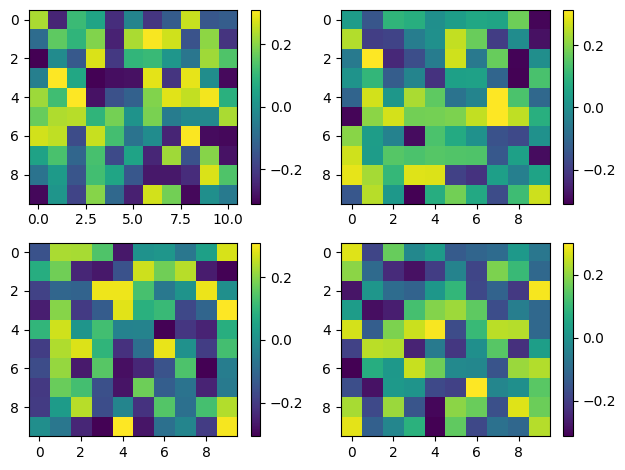

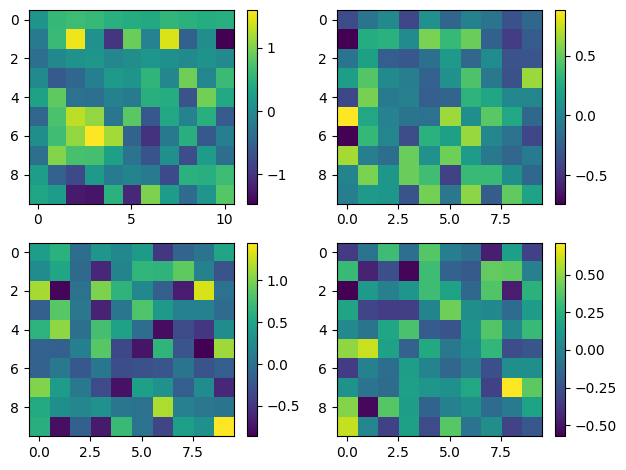

In [78]:
CACHE_DIR = 'cache'

def create_model(all_args):
    decoder = eval(f"{all_args['model']}")
    model = decoder(**all_args['model_args'])
    if 'RNN' in all_args['model']:
        model.init_hidden(all_args['batch_size'])
        model.hidden_state = model.hidden_state.to(all_args['device'])
    return decoder, model

def preprocess_data(all_args):
    # data setup
    train_idx = np.load(TRAIN_DIR/'train_indices.npy')
    test_idx = np.load(TEST_DIR/'test_indices.npy')
    dset = SequenceAlternation(str(FULL_FILE), num_unique, cycle_len)
    train_loader = DataLoader(dset, batch_size=all_args['batch_size'],
                              sampler=train_idx, drop_last=True,
                              pin_memory=True,
                              num_workers=all_args['num_workers'])
    val_loader = DataLoader(dset, batch_size=all_args['batch_size'],
                            sampler=test_idx, drop_last=True, pin_memory=True,
                            num_workers=all_args['num_workers'])

    return train_loader, val_loader

def train_model(all_args):
    preprocessed_data = preprocess_data(all_args)
    train_loader, val_loader = preprocessed_data

    all_args['model_args']['args']['num_training_batches'] = len(train_loader)
    _, model = create_model(all_args)
    model.to(all_args['device'])

    show_weights(model)

    best_ckpt_name_file = os.path.join(CACHE_DIR, 'best_model.txt')
    best_ckpt_path = None
    if os.path.exists(best_ckpt_name_file):
        with open(best_ckpt_name_file, 'r') as f:
            best_ckpt_path = f.read()
    lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="step")
    early_stop = pl.callbacks.early_stopping.EarlyStopping(
        monitor="val_loss", min_delta=0.00, patience=1750,
        verbose=False, mode="min")
    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        save_top_k=1,
        monitor='val_loss',
        dirpath=os.path.join(CACHE_DIR, 'models', 'abc'),
        filename='{epoch:02d}-{val_loss:.2f}',
    )
    logger = pl.loggers.TensorBoardLogger(
        save_dir=str(LOGGING_DIR),
        name=f'{0}',
    )
    pl.seed_everything(all_args['seed'], workers=True)
    trainer = pl.Trainer(
        accelerator=all_args['device'], devices=1,
        max_epochs=all_args['model_args']['args']['epochs'],
        gradient_clip_val=all_args['model_args']['args']['max_grad_norm'],
        accumulate_grad_batches=all_args['model_args']['args']['iters_to_accumulate'],
        logger=logger,
        callbacks=[lr_monitor, checkpoint_callback],
        enable_progress_bar=False,
        log_every_n_steps=5,
        reload_dataloaders_every_n_epochs=1
    )
    trainer.fit(model, train_loader, val_loader, ckpt_path=best_ckpt_path)
    with open(best_ckpt_name_file, 'w') as f:
        f.write(checkpoint_callback.best_model_path)

    show_weights(model)

    return model, trainer, (train_loader, val_loader)

model, trainer, (train_loader, val_loader) = train_model(all_args)

In [80]:
trainer.test(model, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.8924427032470703     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.8924427032470703}]

### Run the network after training, record activity, compute performance

Here we run the network after training. We could have used similar functions as we did in the `train_model` function. But instead we will explicitly loop through individual trials, so we can log the information and compute the performance of each trial.

In [48]:
def load_data(data_dir, indices):
    ohe = OneHotEncoder(max_categories=None, sparse_output=False)
    ohe.fit(np.arange(num_unique + 1).reshape(-1,1))  # 0: no cue

    seq_len = 4 * cycle_len

    X, Y = [], []
    ground_truth = []
    for idx in indices:
        line = linecache.getline(data_dir, idx+2).strip().split(',')
        input_seq = list(map(int, line[:seq_len]))
        input_seq = np.asarray(input_seq)
        input_seq = ohe.transform(input_seq.reshape(-1, 1))
        input_seq = torch.tensor(input_seq, dtype=torch.float32)
        output_seq = list(map(int, line[seq_len:]))
        output_seq = np.asarray(output_seq)
        ground_truth.append(output_seq.ravel())
        output_seq = ohe.transform(output_seq.reshape(-1, 1))
        output_seq = torch.tensor(output_seq, dtype=torch.float32)
        X.append(input_seq)
        Y.append(output_seq)
    return X, Y, ground_truth

test_indices = np.load(TEST_DIR/'test_indices.npy')
X_test, Y_test, ground_truth = load_data(data_dir=str(FULL_FILE), indices=test_indices)

In [16]:
model.eval()
model.to(DEVICE)
with torch.no_grad():
    x = torch.unsqueeze(X_test[0], dim=0).repeat(all_args['batch_size'], 1, 1).to(DEVICE)
    print(torch.argmax(model(x), -1).shape)

torch.Size([512, 16])


In [81]:
# Initialize variables for logging
activations = []  # recording activity
choices = []  # recording trial information
one_hot_choices = []
perf = []

ohe = OneHotEncoder(max_categories=None, sparse_output=False)
ohe.fit(np.arange(num_unique + 1).reshape(-1,1))  # 0: no cue
batch_size = all_args['batch_size']

num_trial = len(X_test)
num_classes = num_unique + 1
model.to(DEVICE)
model.eval()
with torch.no_grad():
    for i in range(num_trial):
        # Convert to numpy, add batch dimension to input
        inputs = torch.unsqueeze(X_test[i], dim=0)
        # Move data to the device used during training (CPU/GPU)
        inputs = inputs.repeat(batch_size, 1, 1).to(DEVICE)

        # Run the network for one trial
        # inputs (Batch, SeqLen, InputSize)
        # out (Batch, SeqLen, OutputSize)
        rnn_activity = model(inputs)

        # Compute performance
        # First convert back to numpy
        rnn_activity = rnn_activity.detach().cpu().numpy()[0, :, :]
        # Read out final choice at last time step
        best_choice_indices = np.argmax(rnn_activity, axis=-1)
        one_hot_choice = np.eye(num_classes)[best_choice_indices]
        choice = ohe.inverse_transform(one_hot_choice).ravel()

        y_hat = ground_truth[i]

        # Compare to ground truth
        accuracy = choice == y_hat
        # if accuracy.mean() < 1: print(accuracy.mean())

        # Record activity, trial information, choice, correctness
        activations.append(model.hidden_state_cache[:, :, 0].detach().cpu().numpy())
        choices.append(choice)
        one_hot_choices.append(one_hot_choice)

print('Average performance:', np.mean(np.ravel(choices) == np.ravel(ground_truth)))

Average performance: 0.9360325727513228


### Plot the network's activity in PCA

Next we will analyze the network by plotting its activity in PCA space. Each trajectory in the PC-space would correspond to a single trial.

In [88]:
# Apply PCA, boilerplate sklearn
from sklearn.decomposition import PCA

# Concatenate activity for PCA
activity1 = np.concatenate(np.stack(activations, axis=0)[:, 0])
activity2 = np.concatenate(np.stack(activations, axis=0)[:, 1])
print('Shape of the neural activity: (Time points, Neurons): ', activity1.shape)

pca1 = PCA(n_components=2)
activity_pc1_all = pca1.fit_transform(activity1)  # activity (Time points, Neurons)

pca2 = PCA(n_components=2)
activity_pc2_all = pca2.fit_transform(activity2)  # activity (Time points, Neurons)

print('Shape of the projected activity: (Time points, PCs): ', activity_pc1_all.shape)

Shape of the neural activity: (Time points, Neurons):  (48384, 10)
Shape of the projected activity: (Time points, PCs):  (48384, 2)


Text(0, 0.5, 'PC 2')

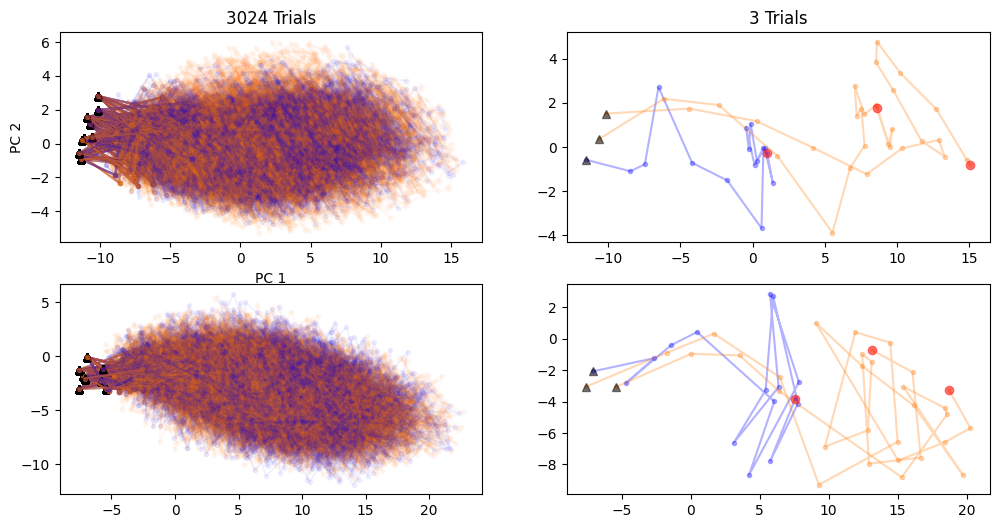

In [114]:
# Project each trial and visualize activity

# Plot all trials in ax1, plot fewer trials in ax2
fig, axs = plt.subplots(2, 2, figsize=(12, 6))

for i in range(num_trial):
    # Transform and plot each trial
    activity_pc1 = pca1.transform(activations[i][0])  # (Time points, PCs)
    activity_pc2 = pca1.transform(activations[i][1])  # (Time points, PCs)

    color = 'tab:orange' if np.any(ground_truth[i] != choices[i]) else 'blue'

    _ = axs[0, 0].plot(activity_pc1[:, 0], activity_pc1[:, 1], '.-', color=color, alpha=.05)
    _ = axs[1, 0].plot(activity_pc2[:, 0], activity_pc2[:, 1], '.-', color=color, alpha=.05)
    if i < 3:
        _ = axs[0, 1].plot(activity_pc1[:, 0], activity_pc1[:, 1], '.-', color=color, alpha=.3)
        _ = axs[0, 1].plot(activity_pc1[0, 0], activity_pc1[0, 1], '^', color='black', alpha=.5)
        _ = axs[0, 1].plot(activity_pc1[-1, 0], activity_pc1[-1, 1], 'o', color='red', alpha=.5)
        _ = axs[1, 1].plot(activity_pc2[:, 0], activity_pc2[:, 1], '.-', color=color, alpha=.3)
        _ = axs[1, 1].plot(activity_pc2[0, 0], activity_pc2[0, 1], '^', color='black', alpha=.5)
        _ = axs[1, 1].plot(activity_pc2[-1, 0], activity_pc2[-1, 1], 'o', color='red', alpha=.5)

    # Plot the beginning of a trial with a special symbol
    _ = axs[0, 0].plot(activity_pc1[-1, 0], activity_pc1[-1, 1], 'o', color='red', alpha=.01)
    _ = axs[0, 0].plot(activity_pc1[0, 0], activity_pc1[0, 1], '^', color='black', alpha=.01)
    _ = axs[1, 0].plot(activity_pc2[-1, 0], activity_pc2[-1, 1], 'o', color='red', alpha=.01)
    _ = axs[1, 0].plot(activity_pc2[0, 0], activity_pc2[0, 1], '^', color='black', alpha=.01)

axs[0, 0].set_title('{:d} Trials'.format(num_trial))
axs[0, 1].set_title('{:d} Trials'.format(3))
axs[0, 0].set_xlabel('PC 1')
axs[0, 0].set_ylabel('PC 2')

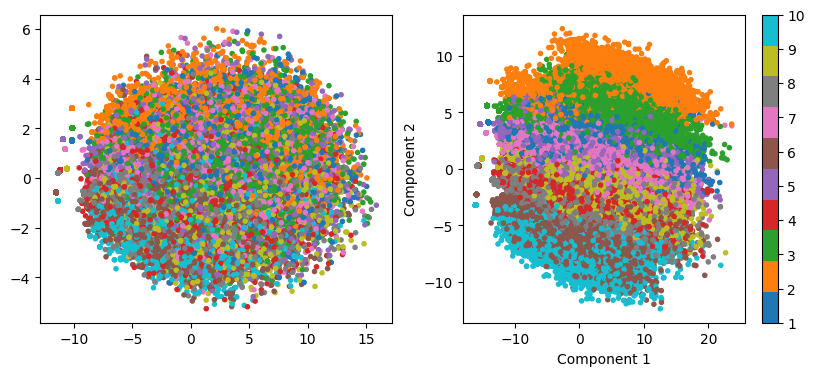

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

all_choices = np.concatenate(choices).ravel()
# all_choices = all_choices / np.max(all_choices)

axes[0].scatter(activity_pc1_all[:, 0], activity_pc1_all[:, 1], marker='.', c=all_choices, cmap='tab10')
scatter = axes[1].scatter(activity_pc2_all[:, 0], activity_pc2_all[:, 1], marker='.', c=all_choices, cmap='tab10')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
colorbar = fig.colorbar(scatter, ax=axes[1], ticks=sorted(np.unique(all_choices)))
colorbar.vmin = -0.5
colorbar.vmax = 9.5

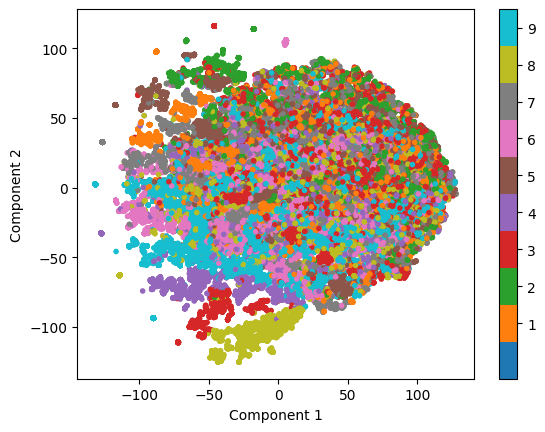

In [113]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, perplexity=30, random_state=SEED)
activity_embed = tsne_model.fit_transform(activity1)  # (Time points, PCs)
all_choices = np.concatenate(choices).ravel()

plt.scatter(activity_embed[:, 0], activity_embed[:, 1], marker='.', c=all_choices, cmap='tab10')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar(ticks=sorted(np.unique(all_choices)))
plt.clim(-0.5, 9.5)

---